In [1]:
import torch
import json
import numpy as np
import pickle
from tqdm import tqdm
from pathlib import Path

import matplotlib.pyplot as plt

from s4hci.utils.data_handling import load_adi_data
from s4hci.models.noise import S4Noise

import torch.nn.functional as F
import torch.multiprocessing as mp

from s4hci.utils.masks import construct_round_rfrr_template, construct_rfrr_mask

## Load the data

In [2]:
print("Loading data ... ", end='')
science_data, raw_angles, raw_psf_template_data = \
    load_adi_data("/fast/mbonse/s4/30_data/HD22049_310_0100_C-0656_A_.hdf5",
                  data_tag="object",
                  psf_template_tag="psf_template",
                  para_tag="header_object/PARANG")

psf_template_data = np.mean(raw_psf_template_data, axis=0)
print("[DONE]")

Loading data ... [DONE]


In [3]:
science_data = science_data[:, 12:-12, 12:-12]

## Init function of S4 Noise

In [4]:
s4_noise_model = S4Noise(
    data_image_size=science_data.shape[1],
    psf_template=psf_template_data,
    lambda_reg=2000,
    cut_radius_psf=4.0,
    mask_template_setup=("radius", 5.5),
    normalization="normal",
    convolve=True,
    verbose=True)

Creating right reason mask ... [DONE]


# Prepare the data

In [5]:
science_data_torch = torch.from_numpy(science_data)

In [6]:
s4_noise_model._prepare_normalization(science_data_torch)
science_data_norm = s4_noise_model.normalize_data(science_data_torch)

Build normalization frames ... [DONE]


## Implement the current math for a single position

In [7]:
half_precision = False
device = 0
positions = [(40, 40), (40, 60), (45, 30), (54, 54)][:2]
lambda_reg = s4_noise_model.lambda_reg
verbose=True

# Compute betas LSTSQ

In [36]:
# get all the data we need as pytroch tensors
X_torch = science_data_norm.float()
p_torch = s4_noise_model.psf_model.float()
M_torch = s4_noise_model.right_reason_mask.float() == 1

In [37]:
from s4hci.utils.s4_rigde import compute_betas, compute_betas_svd

In [38]:
betas_raw = compute_betas(
    X_torch=X_torch,
    M_torch=M_torch,
    lambda_reg=lambda_reg,
    positions=positions,
    mode="LSTSQ",
    p_torch=p_torch,
    device=0,
    fp_precision="float32"
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.15s/it]


In [39]:
image_size=117
mask_sel = []
for x, y in positions:
    tmp_idx = x * image_size + y

    # get the current mask
    m_torch = M_torch[tmp_idx].flatten()
    mask_sel.append(m_torch)
    
mask_final = torch.stack(mask_sel).reshape(
    len(positions), image_size, image_size).float()

In [40]:
def compute_betas(
    betas_raw,
    image_size,
    right_reason_mask,
    psf_model):
    
    # reshape the raw betas
    raw_betas = betas_raw.view(
        -1,
        image_size,
        image_size)

    # set regularization_mask values to zero
    tmp_weights = raw_betas * right_reason_mask

    # convolve the weights
    tmp_weights = F.conv2d(
        tmp_weights.unsqueeze(1),
        psf_model,
        padding="same").view(
        raw_betas.shape[0],
        image_size,
        image_size)

    return tmp_weights

In [41]:
betas_lstsq = compute_betas(betas_raw, 117, mask_final, s4_noise_model.psf_model.float())

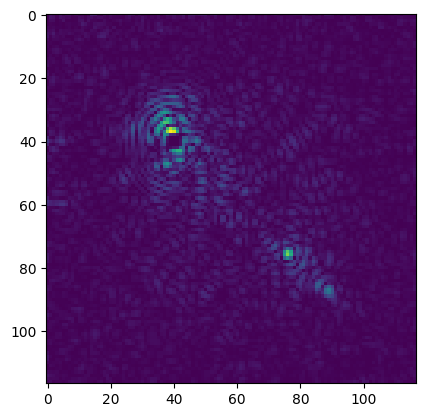

In [42]:
plt.imshow(torch.abs(betas_lstsq[0].reshape(117, 117)))

# Compute the betas with SVD

In [32]:
betas_svd = compute_betas_svd(
    X_torch=X_torch,
    M_torch=M_torch,
    lambda_regs=[lambda_reg,],
    positions=positions,
    p_torch=p_torch,
    approx_svd=10000,
    device=0
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.99s/it]


In [33]:
betas_svd.shape

torch.Size([2, 117, 117])

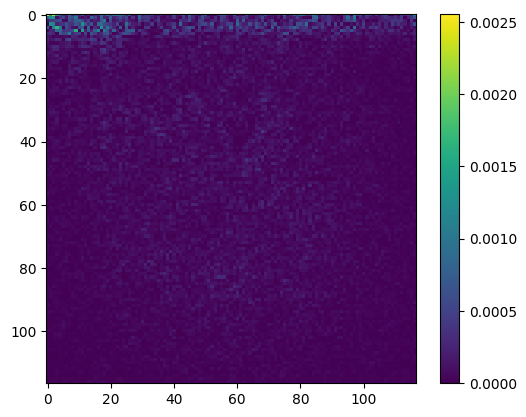

In [35]:
plt.imshow(torch.abs(betas_svd[1] - betas_lstsq[1].reshape(117, 117)))
plt.colorbar()